# **Data Mining and Machine Learning - Team Tissot**

***Detecting the difficulty level of French texts***


In this notebook we will show the following:


1. Importing necessary packages and functions

2. Taking a look at the data

3. Logistic Regression without data cleaning

4. Knn Classifier without data cleaning

5. Decision Tree Classifier without data cleaning

6. Random Forest Classifier without data cleaning










#  1. Importing packages and functions

In [8]:
# importing packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from wordcloud import WordCloud   
sns.set_style("whitegrid")

# import some additional packages for training models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# import tqdm (progress bar)
from tqdm import tqdm

# import files to download .csv
from google.colab import files

> Additional custom functions from our github repo



In [9]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import requests

In [ ]:
url = 'https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/code/custom_functions.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('custom_functions.py', 'w') as f:
    f.write(r.text)
print(r.text)
# now we can import
import custom_functions as cfun

à garder si on garde le scatter plot ici:

In [5]:
from nltk.tokenize import word_tokenize, sent_tokenize 
import string
punctuations = string.punctuation

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 2. Visualizing the data

**Loading the data and setting "id" as the index column**

In [59]:
# training data:
dfTrain = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/training_data.csv", index_col='id')

# unlabeled test data:
dfTest = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/unlabelled_test_data.csv", index_col='id')

**Taking a look at the data**

In [11]:
dfTrain

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2


In [12]:
dfTest

,sentence
id,
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...
1195,C'est un phénomène qui trouve une accélération...
1196,Je vais parler au serveur et voir si on peut d...
1197,Il n'était pas comme tant de gens qui par pare...


**Checking for irregularity like null values or duplicate sentences in dfTrain**

In [13]:
dfTrain.isnull().sum()

sentence      0
difficulty    0
dtype: int64

In [14]:
dfTrain.duplicated(subset="sentence").value_counts()

False    4800
dtype: int64



> No null values or duplicates



**World clouds**

In [15]:
def wordcloud_function(df, title, column, fontsize = 15, 
                       figsize = (10, 10), width = 300, height = 300):
    total_text = ''.join([text for text in df[column]])
    wordcloud = WordCloud(width = width, height = height).generate(total_text)
    plt.figure(figsize = figsize)
    plt.imshow(wordcloud)
    plt.title(title, fontsize = fontsize)
    plt.show()
   

In [16]:
 sns.set_style("white")

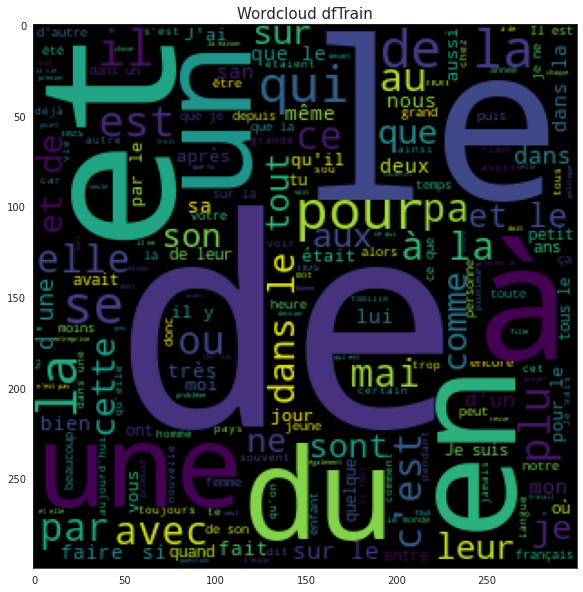

In [17]:
wordcloud_function(dfTrain, title = "Wordcloud dfTrain", column = "sentence")

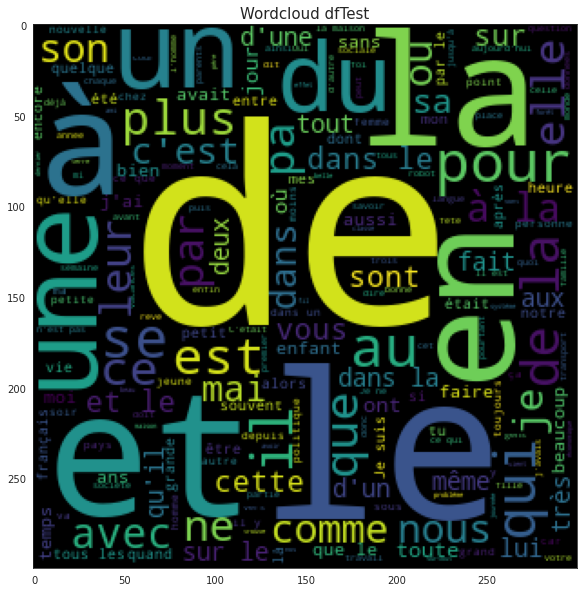

In [18]:
wordcloud_function(dfTest, title = "Wordcloud dfTest", column = "sentence")



> The two world clouds appear to have similar top words



**Distribution of difficulty**

In [19]:
def plot_histogram(dataframe: pd.DataFrame, column: str, x_title = None, y_title = None, edge_color = 'black', 
                   color = 'Green', total_bins = 20, font_size = 10):
    
    fig, ax = plt.subplots(figsize = (10, 5))   
    ax.hist(dataframe[column], bins = total_bins, edgecolor = edge_color, color = color)
    ax.set_title(f'Histogram Distribution of {column} values', fontsize = font_size + 5)
    ax.set_xlabel(column, fontsize = font_size)
    ax.set_ylabel("Total Number of Observations", fontsize = font_size)
    plt.show()

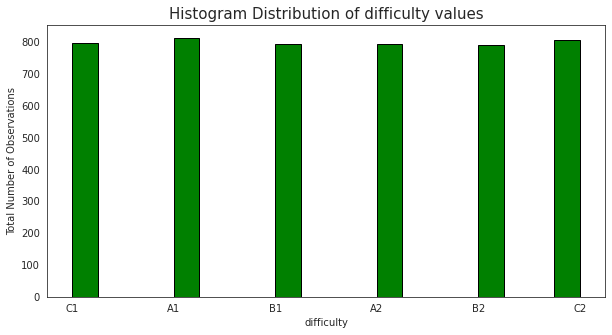

In [20]:
plot_histogram(dfTrain,column='difficulty')



> No strong imbalance in difficulty distribution



**Baseline**

In [21]:
distribution = dfTrain['difficulty'].value_counts() 
distribution

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

In [22]:
maj_bas = (distribution / len(dfTrain)).max()
print("The majority class baseline is: %s" % maj_bas)

The majority class baseline is: 0.169375


> Since our classes are almost equally balanced, a random classifier will achieve an accuracy of approximately 1/n, where n is the number of classes. 

> In our case it would be:  ~1/6 = 0.166...



##à voir si on laisse ici

In [23]:
def get_info(df):
 
    text_length = []                          
    number_of_sentences = []
    number_of_words = []
    sent_length_avg = []
    words_length_avg = []
    number_of_words_after_lemma_stop = []
    longest_word_size = []
    
    for text in tqdm(df['sentence'].values):
        
      initial_length = len(text)
      text_length.append(initial_length)
      #print("sentence_length: %s" % text_length)

      num_sentences = len(sent_tokenize(text))
      number_of_sentences.append(num_sentences)
      #print("number_of_sentences: %s" % number_of_sentences)

      text2 = text.lower()
      text2 = word_tokenize(text2)
      text2 = [word for word in text2 if word not in punctuations]
      #print(text2)
      num_words = len(text2)
      number_of_words.append(num_words)
      #print("number_of_words %s" %number_of_words)

      sent_length_avg.append(num_words/num_sentences)
      #print("sent_length_avg: %s" %sent_length_avg)

      words_length_avg.append(initial_length/num_words)
      #print("words_length_avg: %s" %words_length_avg)


        
    final_df = pd.concat([pd.Series(text_length), pd.Series(number_of_sentences),
                             pd.Series(number_of_words), pd.Series(sent_length_avg),
                             pd.Series(words_length_avg), pd.Series(dfTrain['difficulty'])], axis = 1)
    final_df.columns = ["text_length", "number_of_sentences", "number_of_words",
                           "sent_length_avg", "words_length_avg", "difficulty"
                           ]
    
    return final_df

In [24]:
def get_info(df):
 
    text_length = []                          
    number_of_sentences = []
    number_of_words = []
    sent_length_avg = []
    words_length_avg = []
    number_of_words_after_lemma_stop = []
    longest_word_size = []
    
    for text in tqdm(df['sentence'].values):
        
      initial_length = len(text)
      text_length.append(initial_length)
      #print("sentence_length: %s" % text_length)

      num_sentences = len(sent_tokenize(text))
      number_of_sentences.append(num_sentences)
      #print("number_of_sentences: %s" % number_of_sentences)

      text2 = text.lower()
      text2 = word_tokenize(text2)
      text2 = [word for word in text2 if word not in punctuations]
      #print(text2)
      num_words = len(text2)
      number_of_words.append(num_words)
      #print("number_of_words %s" %number_of_words)

      sent_length_avg.append(num_words/num_sentences)
      #print("sent_length_avg: %s" %sent_length_avg)

      words_length_avg.append(initial_length/num_words)
      #print("words_length_avg: %s" %words_length_avg)


        
    final_df = pd.concat([pd.Series(text_length), pd.Series(number_of_sentences),
                             pd.Series(number_of_words), pd.Series(sent_length_avg),
                             pd.Series(words_length_avg)], axis = 1)
    final_df.columns = ["text_length", "number_of_sentences", "number_of_words",
                           "sent_length_avg", "words_length_avg",
                           ]
    
    return final_df

In [25]:
dfTrainVisualization = get_info(dfTrain)

100%|██████████| 4800/4800 [00:00<00:00, 6806.61it/s]


In [26]:
dfTrainViz = pd.concat([dfTrain, dfTrainVisualization], axis = 1)

In [27]:
dfTrain

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2


In [28]:
dfTrainVisualization

,text_length,number_of_sentences,number_of_words,sent_length_avg,words_length_avg
0,255,1,38,38.0,6.710526
1,62,1,12,12.0,5.166667
2,66,1,13,13.0,5.076923
3,40,1,8,8.0,5.000000
4,209,1,36,36.0,5.805556
...,...,...,...,...,...
4795,165,1,26,26.0,6.346154
4796,118,1,21,21.0,5.619048
4797,80,1,13,13.0,6.153846
4798,226,1,32,32.0,7.062500


In [29]:
dfTrainViz = dfTrainViz.sort_values('difficulty')

In [30]:
dfTrainViz

,sentence,difficulty,text_length,number_of_sentences,number_of_words,sent_length_avg,words_length_avg
4582,"Je suis dans le bus, j'arrive dans 5 minutes.",A1,45,1,9,9.0,5.000000
576,C'est bientôt l'anniversaire de Julie.,A1,38,1,5,5.0,7.600000
977,Vous avez des enfants ?,A1,23,1,4,4.0,5.750000
4579,"Le temps devient de plus en plus frais, il com...",A1,85,1,19,19.0,4.473684
579,Tu parles bien anglais.,A1,23,1,4,4.0,5.750000
...,...,...,...,...,...,...,...
3993,Un enfant bilingue est éminemment favorisé par...,C2,147,1,21,21.0,7.000000
3994,"Les méthodes de la biologie synthétique, qui a...",C2,310,1,47,47.0,6.595745
3995,"À l'aise devant la vie, séduisant, nonchalant,...",C2,169,1,22,22.0,7.681818
2073,"""Comment voulez-vous demander une analyse gram...",C2,159,2,23,11.5,6.913043


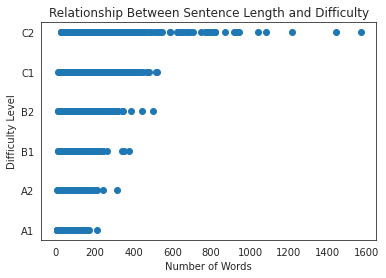

In [31]:
import matplotlib.pyplot as plt

# Extract data from dataframe
word_length = dfTrainViz['text_length'].tolist()
difficulty = dfTrainViz['difficulty'].tolist()


# # Create scatter plot
plt.scatter(word_length, difficulty)
plt.xlabel('Number of Words')
plt.ylabel('Difficulty Level')
plt.title('Relationship Between Sentence Length and Difficulty')
plt.show()

In [32]:
difficulty_map = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}

# Convert the difficulty levels in the dataframe to integers using the mapping
dfTrainViz['difficulty_n'] = dfTrainViz['difficulty'].map(difficulty_map)

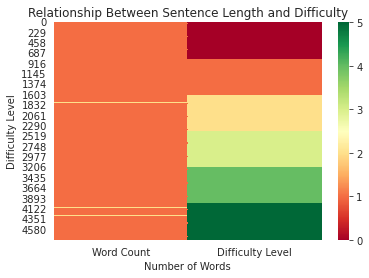

In [33]:
import seaborn as sns

# Extract data from dataframe
nbr_words = dfTrainViz['number_of_sentences'].tolist()
difficulty = dfTrainViz['difficulty_n'].tolist()



# Create dataframe with sentence length and difficulty level data
data = {'Word Count': nbr_words, 'Difficulty Level': difficulty}
df_heatmap = pd.DataFrame(data)

# Create heatmap
sns.heatmap(df_heatmap, cmap='RdYlGn')
plt.xlabel('Number of Words')
plt.ylabel('Difficulty Level')
plt.title('Relationship Between Sentence Length and Difficulty')
plt.show()

**Scatter plot between word length and difficulty**

In [34]:
X = dfTrain["sentence"]
y = dfTrain["difficulty"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# **First part of the project**

*Training models without data cleaning (Logistic regression, KNN, Decision Tree, Random Forests)*

Before training our models, let's split the data and define the Tfidf Vectorizer

In [35]:
# Defining X and y
X = dfTrain["sentence"]
y = dfTrain["difficulty"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# defining Vectorizer with default tokenizer
tfidf_vector = TfidfVectorizer(ngram_range=(1,1)) 

# 3. Logistic Regression (without data cleaning)

A simple logistic regression model using a Tfidf vectoriser. 


In [36]:
# A SUPPRIMER
#function to calculate metrics of the models
def models_metrics (true, pred):
  precision = precision_score(true, pred, average='weighted')
  recall = recall_score(true, pred, average='weighted')
  f1 = f1_score(true, pred, average='weighted')
  print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred,)}")
  print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
  print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
# Defining classifier
LR = LogisticRegression(random_state = 0)

# defining pipeline with the tfidf vectorizer 
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

# Fitting the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(random_state=0))])

In [39]:
# predicting on the test set
y_pred_lr = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.4604,0.4582,0.4604,0.4561


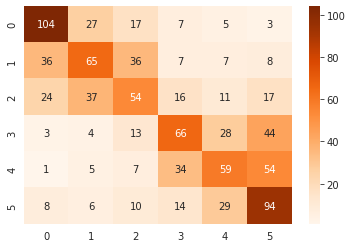

In [40]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_lr)

This model seems more fairly more accurate for the difficulty levels A1 and C2 (0 and 5) than for the other difficulties.

### peut-être à garder

In [41]:
unique, counts = np.unique(y_test, return_counts=True)
target = dict(zip(unique, counts))

In [42]:
target

{'A1': 163, 'A2': 159, 'B1': 159, 'B2': 158, 'C1': 160, 'C2': 161}

In [43]:
# Get the diagonal of the confusion matrix
diagonal = confusion_matrix(y_test, y_pred_lr).diagonal()
diagonal

array([104,  65,  54,  66,  59,  94])

In [44]:
# Divide the values in the diagonal array by the values in the dictionary
percentages = diagonal / np.array(list(target.values()))
percentages

array([0.63803681, 0.40880503, 0.33962264, 0.41772152, 0.36875   ,
       0.58385093])

In [45]:
# Print the percentages for each key
for index, key in enumerate(target.keys()):
    print(f'{key}: {percentages[index]:.2f}%')

A1: 0.64%
A2: 0.41%
B1: 0.34%
B2: 0.42%
C1: 0.37%
C2: 0.58%


In [46]:
f1_score(y_test, y_pred_lr, average = None)

array([0.61356932, 0.4290429 , 0.36486486, 0.43708609, 0.39464883,
       0.49343832])

In [47]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{'A1': 163, 'A2': 159, 'B1': 159, 'B2': 158, 'C1': 160, 'C2': 161}

In [48]:
unique, counts = np.unique(y_pred_lr, return_counts=True)
dict(zip(unique, counts))


{'A1': 176, 'A2': 144, 'B1': 137, 'B2': 144, 'C1': 139, 'C2': 220}

### à garder:

**A few examples of sentences that are not well classified**

In [49]:
X_test[(y_test != y_pred_lr)].iloc[0:5]

id
2003    Il est également connu pour ses publicités tél...
2585    Edgar, étincelant de furie, dominait tous les ...
2302                                    Ils sont heureux.
2958    Les canons renversèrent d'abord à peu près six...
3862    Parce que la philosophie se trouve de plus en ...
Name: sentence, dtype: object

In [50]:
print(X_test[(y_test != y_pred_lr)].iloc[0])
print("Difficulty level :", y_test[2003])
print("Predicted difficulty level :", y_pred_lr[0])

Il est également connu pour ses publicités télévisées à faible budget et ses affiches imprimées à Albuquerque, dans lesquels il s'annonce principalement sous le slogan : "Appelez donc Saul !"
Difficulty level : C1
Predicted difficulty level : C2


In [51]:
print(X_test[(y_test != y_pred_lr)].iloc[3])
print("The level of difficulty :", y_test[2958])
print("The predicted level of difficulty :", y_pred_lr[3])

Les canons renversèrent d'abord à peu près six mille hommes de chaque côté ; ensuite la mousqueterie ôta du meilleur des mondes environ neuf à dix mille coquins qui en infectaient la surface.
The level of difficulty : C1
The predicted level of difficulty : A1


**First predictions on** `unlabelled_test_data.csv` **(dfTest)**

first, let's the fit on the whole data

In [52]:
pipe.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(random_state=0))])

In [53]:
# predict difficulty from dfTest
predDifficulty = pipe.predict(dfTest['sentence'])

In [57]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(predDifficulty, "LogisticRegression", download = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,difficulty
id,
0,C2
1,A2
2,A1
3,A1
4,C2


**Submission is a Logistic Regression without data cleaning**

**Submission score: 0.46583**



# 4. KNN Classifier (without data cleaning)


In [61]:
# import some additional packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [85]:
# Defining classifier
knn = KNeighborsClassifier()

# defining pipeline with the tfidf vectorizer
pipe = Pipeline(steps = [('vectorizer', tfidf_vector),
                 ('classifier', knn)])

# Fitting the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', KNeighborsClassifier())])

In [65]:
# predicting on the test set
y_pred_knn = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.3156,0.3826,0.3156,0.2921


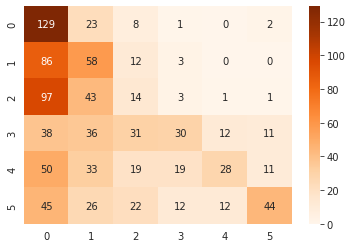

In [66]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_knn)

This model performed severely worse than the Logistic Regression. It seems pretty imbalaced towards the low difficulties (A1 and A2)

Example of sentences not well classified

//todo

**KNN Hyper Parameters tuning**

In [67]:
# Import Grid Search - hyperparameter tuning
from sklearn.model_selection import GridSearchCV

Let's use those parameters


In [76]:
# Defining model
knn = KNeighborsClassifier()

# Defining pipeline
pipe = Pipeline(steps = [('vectorizer', tfidf_vector),
                 ('classifier', knn)])

# Defining parameters to test
param_grid = {'classifier__n_neighbors':np.arange(1,40),
        'classifier__p':np.arange(1,3),
        'classifier__weights':['uniform','distance']
       }


search = GridSearchCV(pipe, param_grid, cv = 10)
search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39]),
                         'classifier__p': array([1, 2]),
                         'classifier__weights': ['uniform', 'distance']})

In [78]:
print("Hyperparameters:", search.best_params_)
print("Train Score:", round(search.best_score_, 4))
print("Test Score:", round(search.score(X_test, y_test), 4))

Hyperparameters: {'classifier__n_neighbors': 18, 'classifier__p': 2, 'classifier__weights': 'distance'}
Train Score: 0.3581
Test Score: 0.351


Now let's fit our model once again using the best parameters found

In [91]:
# Define classifier
knn = KNeighborsClassifier(n_neighbors = 18, p = 2, weights = 'distance')

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
              ('classifier', knn)])

# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=18, weights='distance'))])

In [87]:
# predicting on the test set
y_pred_knn = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.351,0.3928,0.351,0.3391


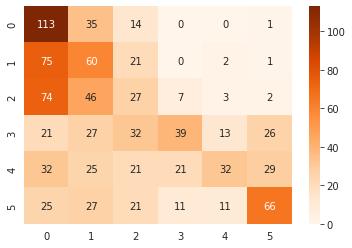

In [88]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_knn)

Tuning the model slightly improved the imbalace, but the model remains skewed. 

Example of sentences not well classified

//todo

**Prediction on the unlabelled_test_data.csv (dfTest)**

first, let's the fit on the whole data

In [89]:
pipe.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=18, weights='distance'))])

In [90]:
# predict difficulty from dfTest
predDifficulty = pipe.predict(dfTest['sentence'])

In [92]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(predDifficulty, "KnnTuning", True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,difficulty
id,
0,C2
1,A2
2,A1
3,A1
4,C2


**This submission is a Hyper Paramaters tuned KNN classifier without data cleaning**

**Submission score: 0.33833**

# 5. Decision Tree (without data cleaning)


**Decision Tree Classification without Hyper Parameters tuning**

In [138]:
# import some additional packages 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

In [139]:
# Defining classifier
tree = DecisionTreeClassifier(random_state = 0)

# defining pipeline with the tfidf vectorizer
pipe = Pipeline(steps = [('vectorizer', tfidf_vector),
                 ('classifier', tree)])

# Fitting the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [140]:
# predicting on the test set
y_pred_tree = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.3083,0.3055,0.3083,0.3055


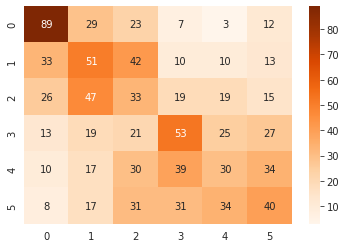

In [141]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_tree)

example not classified : todo

**Decision Tree Classifier Parameters Tuning**

In [142]:
# Defining model
tree = DecisionTreeClassifier()

# Defining pipeline
pipe = Pipeline(steps = [('vectorizer', tfidf_vector),
                 ('classifier', tree)])

# Defining parameters to test
param_grid = {'classifier__max_depth': np.arange(1,200)}


search = GridSearchCV(pipe, param_grid, cv = 10)
search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        6...
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,


In [143]:
print("Hyperparameters:", search.best_params_)
print("Train Score:", round(search.best_score_, 4))
print("Test Score:", round(search.score(X_test, y_test), 4))

Hyperparameters: {'classifier__max_depth': 9}
Train Score: 0.3242
Test Score: 0.3115


**Now let's fit our model once again using the best parameters found**

In [144]:
# Define classifier
classifier = DecisionTreeClassifier(max_depth = 10,random_state = 0)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
              ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, random_state=0))])

In [145]:
# predicting on the test set
y_pred_tree = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.3219,0.3159,0.3219,0.3


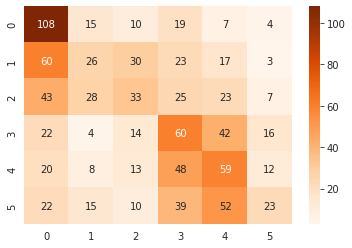

In [146]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_tree)

comments todo

**Predictions on the `unlabelled_test_data.csv` (dfTest)**

first, let's the fit on the whole data

In [147]:
pipe.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, random_state=0))])

In [148]:
# predict difficulty from dfTest
predDifficulty = pipe.predict(dfTest['sentence'])

In [149]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(predDifficulty, "DecisionTreeTuning", True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,difficulty
id,
0,C2
1,B1
2,A1
3,A1
4,B2


**Submission is a Hyper Parameters tuned Decision Tree classifier without data cleaning**

**score: 0.3175**

# 6. Random Forests (without data cleaning)


In [132]:
# import some additional packages
from sklearn.ensemble import RandomForestClassifier

In [133]:
# Define classifier
forest = RandomForestClassifier(random_state = 0)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', forest)])

# Fit model on training set
pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.4062,0.4073,0.4062,0.3932


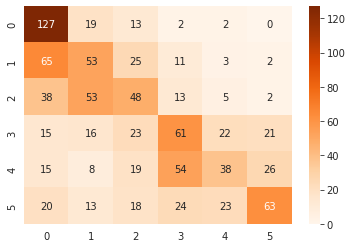

In [134]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred)

**Predictions on** `unlabelled_test_data.csv` **(dfTest)**

first, let's the fit on the whole data

In [135]:
pipe.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier(random_state=0))])

In [136]:
# predict difficulty from dfTest
predDifficulty = pipe.predict(dfTest['sentence'])

In [137]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(predDifficulty, "RandomForestClassifier", download = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,difficulty
id,
0,B2
1,B1
2,A2
3,A1
4,C2


**This Submission is a Random Forest Classification without data cleaning**

**Submission score: 0.395**



---




# 7. Results Summary